<a href="https://colab.research.google.com/github/bradleyboehmke/colab/blob/master/lstm-quora-similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages(c('keras', 'tidyverse'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rappdirs’, ‘config’, ‘reticulate’, ‘tensorflow’, ‘tfruns’




In [2]:
library(keras)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [0]:
quora_data <- get_file(
  "quora_duplicate_questions.tsv",
  "http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv"
)

In [4]:
df <- read_tsv(quora_data)
head(df)

Parsed with column specification:
cols(
  id = col_double(),
  qid1 = col_double(),
  qid2 = col_double(),
  question1 = col_character(),
  question2 = col_character(),
  is_duplicate = col_double()
)



id,qid1,qid2,question1,question2,is_duplicate
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0
5,11,12,Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?,"I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?",1


In [0]:
vocab_size <- 50000
max_len <- 20
embedding_size <- 256
seq_embedding_size <- 512

In [0]:
tokenizer <- text_tokenizer(num_words = vocab_size)
fit_text_tokenizer(tokenizer, x = c(df$question1, df$question2))

question1 <- texts_to_sequences(tokenizer, df$question1)
question2 <- texts_to_sequences(tokenizer, df$question2)

question1 <- pad_sequences(question1, maxlen = max_len, value = vocab_size + 1)
question2 <- pad_sequences(question2, maxlen = max_len, value = vocab_size + 1)

In [16]:
input1 <- layer_input(shape = c(max_len))
input2 <- layer_input(shape = c(max_len))

embedding <- layer_embedding(
  input_dim = vocab_size + 2, 
  output_dim = embedding_size, 
  input_length = max_len, 
  embeddings_regularizer = regularizer_l2(l = 0.0001)
)
seq_emb <- layer_lstm(
  units = seq_embedding_size, 
  recurrent_regularizer = regularizer_l2(l = 0.0001)
)

vector1 <- embedding(input1) %>%
  seq_emb()
vector2 <- embedding(input2) %>%
  seq_emb()

out <- layer_dot(list(vector1, vector2), axes = 1) %>%
  layer_dense(1, activation = "sigmoid")

model <- keras_model(list(input1, input2), out)
model %>% compile(
  optimizer = "adam", 
  loss = "binary_crossentropy", 
  metrics = "accuracy"
)

summary(model)

Model: "model_2"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_5 (InputLayer)      [(None, 20)]      0                                   
________________________________________________________________________________
input_6 (InputLayer)      [(None, 20)]      0                                   
________________________________________________________________________________
embedding_2 (Embedding)   (None, 20, 256)   12800512 input_5[0][0]              
                                                     input_6[0][0]              
________________________________________________________________________________
lstm_2 (LSTM)             (None, 512)       1574912  embedding_2[0][0]          
                                                     embedding_2[1][0]          
________________________________________________________________________________
dot_2 (Dot)

In [17]:
start <- Sys.time()

set.seed(1817328)
val_sample <- sample.int(nrow(question1), size = 0.1*nrow(question1))

history <- model %>%
  fit(
    list(question1[-val_sample,], question2[-val_sample,]),
    df$is_duplicate[-val_sample], 
    batch_size = 128, 
    epochs = 30, 
    validation_data = list(
      list(question1[val_sample,], question2[val_sample,]), df$is_duplicate[val_sample]
    ),
    callbacks = list(
      callback_early_stopping(patience = 5),
      callback_reduce_lr_on_plateau(patience = 3)
    )
  )

end <- Sys.time()
end - start

Time difference of 57.80711 mins

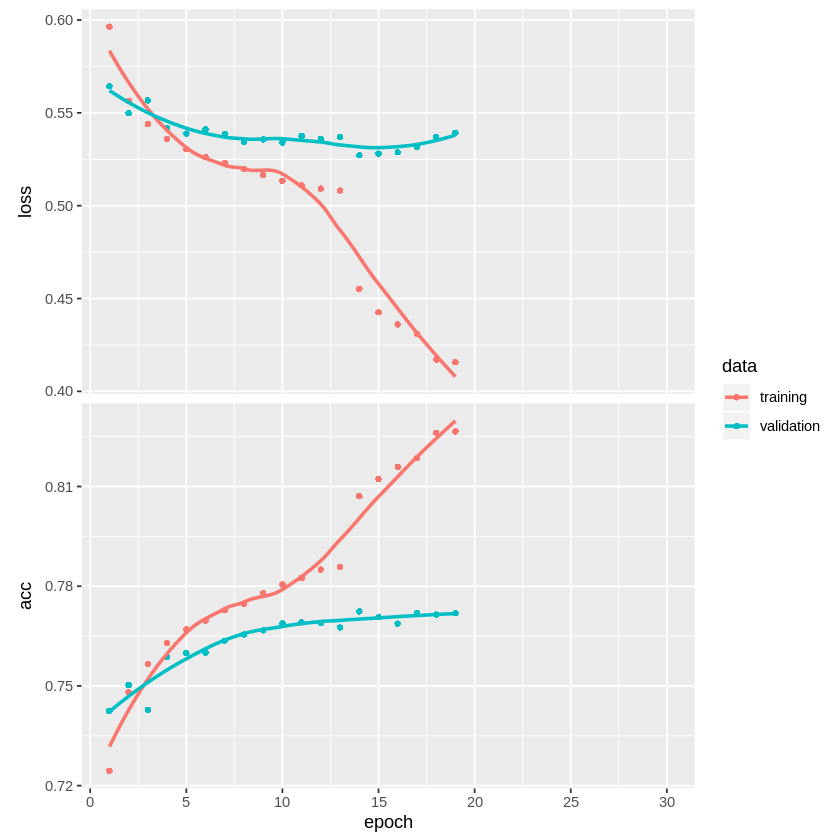

In [18]:
plot(history)

In [21]:
best_epoch <- which(history$metrics$val_loss == min(history$metrics$val_loss))
loss <- history$metrics$val_loss[best_epoch] %>% round(3)
acc <- history$metrics$val_acc[best_epoch] %>% round(3)

glue::glue("The best epoch had a loss of {loss} and an accuracy of {acc}")

The best epoch had a loss of 0.527 and an accuracy of 0.772